# Keras Classification

<span class="girk">We have a dataset in which there are details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.</span>

---
---

## Import  libraries & data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (12, 6)
# plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")
import warnings

warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv("Churn_Modelling.csv", index_col='RowNumber')
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.000,1,1,1,101348.880,1
2,15647311,Hill,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0
3,15619304,Onio,502,France,Female,42,8,159660.800,3,1,0,113931.570,1
4,15701354,Boni,699,France,Female,39,1,0.000,2,0,0,93826.630,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0


## Exploratory Data Analysis and Visualization

In [4]:
# !pip install pandasgui

In [5]:
# from pandasgui import show

# gui = show(df)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


In [7]:
df.shape

(10000, 13)

In [8]:
df.isnull().sum().any()

False

In [9]:
df.duplicated().sum()

0

In [10]:
df.describe().T



,count,mean,std,min,25%,50%,75%,max
CustomerId,10000.000,15690940.569,71936.186,15565701.000,15628528.250,15690738.000,15753233.750,15815690.000
CreditScore,10000.000,650.529,96.653,350.000,584.000,652.000,718.000,850.000
Age,10000.000,38.922,10.488,18.000,32.000,37.000,44.000,92.000
Tenure,10000.000,5.013,2.892,0.000,3.000,5.000,7.000,10.000
Balance,10000.000,76485.889,62397.405,0.000,0.000,97198.540,127644.240,250898.090
NumOfProducts,10000.000,1.530,0.582,1.000,1.000,1.000,2.000,4.000
HasCrCard,10000.000,0.706,0.456,0.000,0.000,1.000,1.000,1.000
IsActiveMember,10000.000,0.515,0.500,0.000,0.000,1.000,1.000,1.000
EstimatedSalary,10000.000,100090.240,57510.493,11.580,51002.110,100193.915,149388.247,199992.480
Exited,10000.000,0.204,0.403,0.000,0.000,0.000,0.000,1.000


<AxesSubplot:>

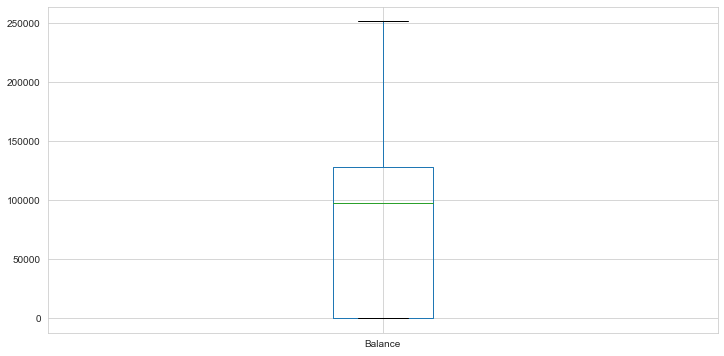

In [11]:
df.Balance.plot(kind="box")

In [12]:
df.drop(['CustomerId', 'Surname'], axis=1, inplace=True)

0    7963
1    2037
Name: Exited, dtype: int64


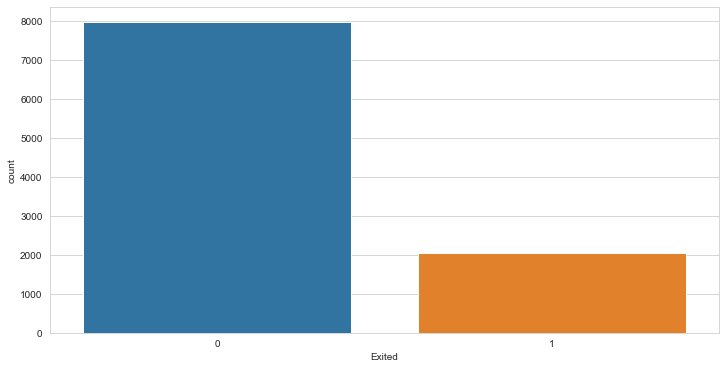

In [13]:
print(df.Exited.value_counts())
sns.countplot(df["Exited"]);

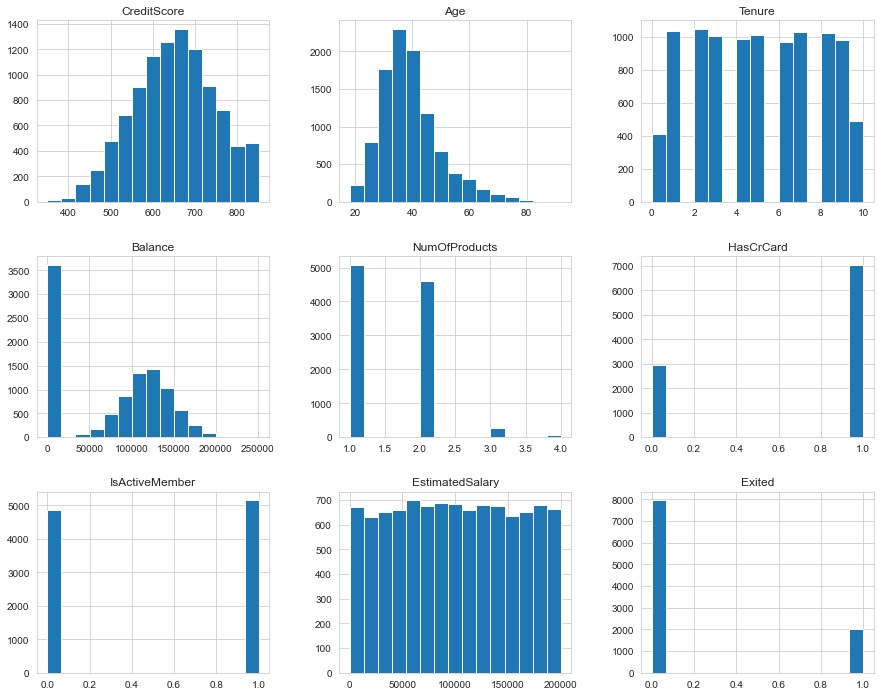

In [14]:
df.hist(figsize=(15, 12), bins=15);


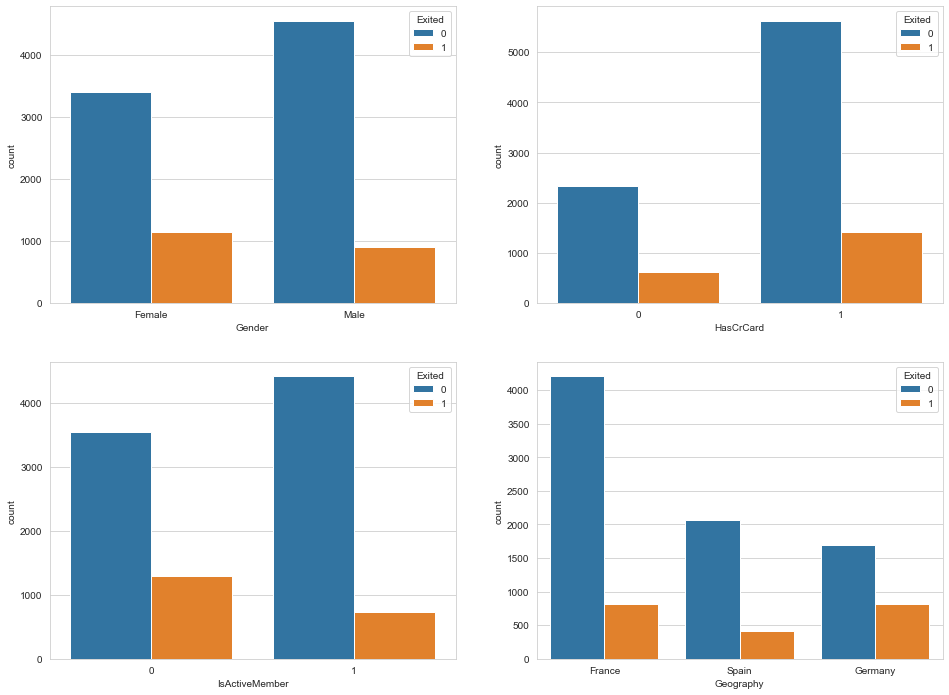

In [15]:
cat_list = ["Gender", "HasCrCard", "IsActiveMember", "Geography"]
index = 0
plt.figure(figsize=(16, 12))
for i in cat_list:
    index += 1
    plt.subplot(2, 2, index)
    sns.countplot(data=df, x=i, hue="Exited")

In [16]:
df.groupby("Age")["Exited"].value_counts()


Age  Exited
18   0         20
     1          2
19   0         26
     1          1
20   0         38
               ..
84   0          1
     1          1
85   0          1
88   0          1
92   0          2
Name: Exited, Length: 128, dtype: int64

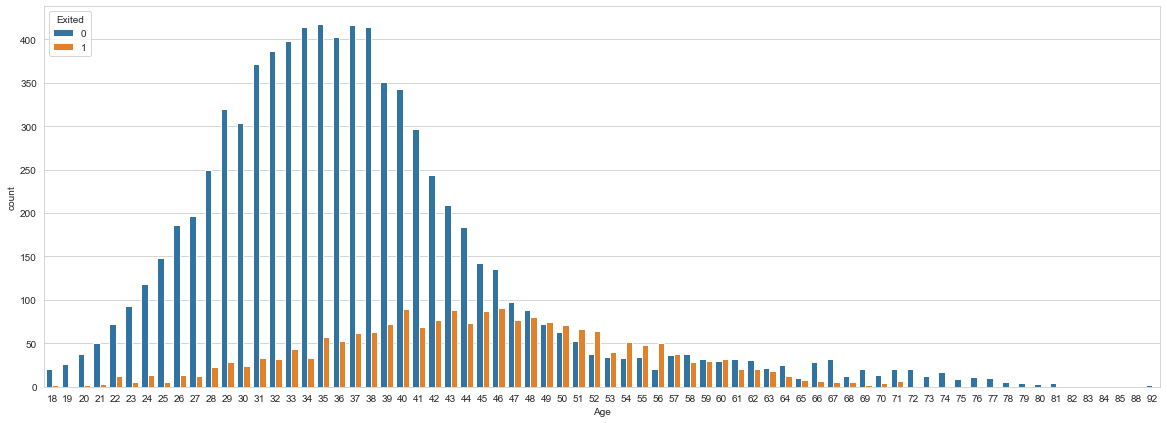

In [17]:
plt.figure(figsize=(20, 7))
sns.countplot(df.Age, hue=df.Exited);

In [18]:
df.CreditScore.describe()

count   10000.000
mean      650.529
std        96.653
min       350.000
25%       584.000
50%       652.000
75%       718.000
max       850.000
Name: CreditScore, dtype: float64

In [19]:
def credit_transformer(x, y):
    if x < 584 and y == 0:
        return 0
    if x < 584 and y == 1:
        return 1
    if 584 < x < 718 and y == 0:
        return 2
    if 584 < x < 718 and y == 1:
        return 3
    else:
        return 4

In [20]:
customer_value = [
    credit_transformer(x, y) for x, y in zip(df.CreditScore, df.HasCrCard)
]
customer_value[:10]

[3, 2, 1, 2, 4, 3, 4, 1, 0, 3]

In [21]:
set(customer_value)

{0, 1, 2, 3, 4}

In [22]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,619,France,Female,42,2,0.000,1,1,1,101348.880,1
2,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0
3,502,France,Female,42,8,159660.800,3,1,0,113931.570,1
4,699,France,Female,39,1,0.000,2,0,0,93826.630,0
5,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0
...,...,...,...,...,...,...,...,...,...,...,...
9996,771,France,Male,39,5,0.000,2,1,0,96270.640,0
9997,516,France,Male,35,10,57369.610,1,1,1,101699.770,0
9998,709,France,Female,36,7,0.000,1,0,1,42085.580,1


In [23]:
df.insert(10, "customer_value", customer_value)

In [24]:
df.customer_value

RowNumber
1        3
2        2
3        1
4        2
5        4
        ..
9996     4
9997     1
9998     2
9999     4
10000    4
Name: customer_value, Length: 10000, dtype: int64

from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()

result = encoder.fit_transform(df.customer_value.values.reshape(-1, 1))
print(result)


df.customer_value = result
df.customer_value

In [25]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,customer_value,Exited
RowNumber,,,,,,,,,,,,
1,619,France,Female,42,2,0.000,1,1,1,101348.880,3,1
2,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,2,0
3,502,France,Female,42,8,159660.800,3,1,0,113931.570,1,1
4,699,France,Female,39,1,0.000,2,0,0,93826.630,2,0
5,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9996,771,France,Male,39,5,0.000,2,1,0,96270.640,4,0
9997,516,France,Male,35,10,57369.610,1,1,1,101699.770,1,0
9998,709,France,Female,36,7,0.000,1,0,1,42085.580,2,1


<AxesSubplot:>

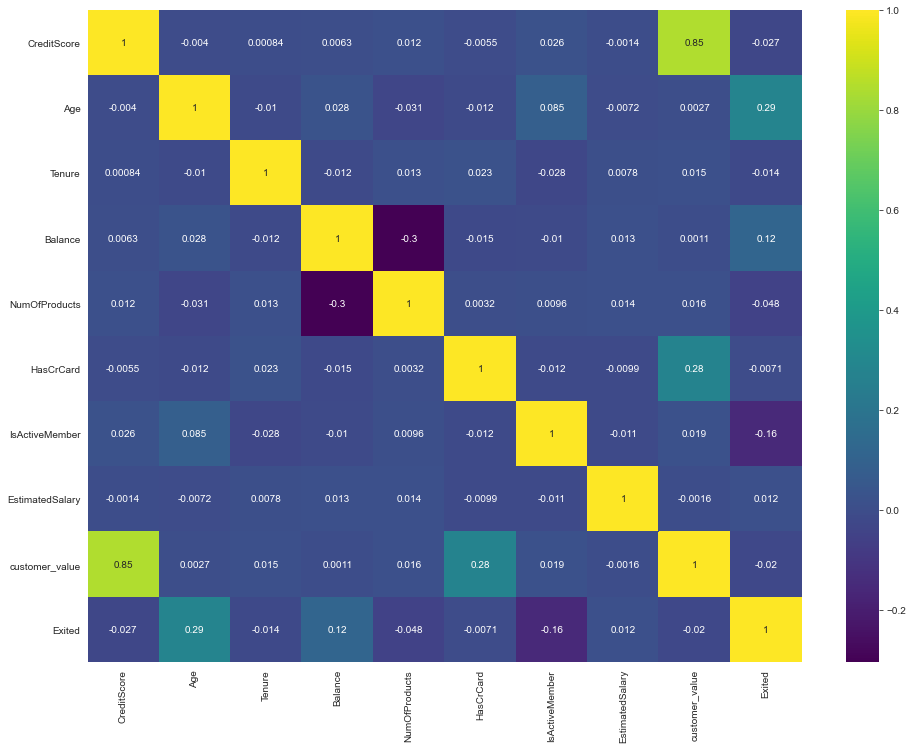

In [26]:
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(), annot=True, cmap='viridis')

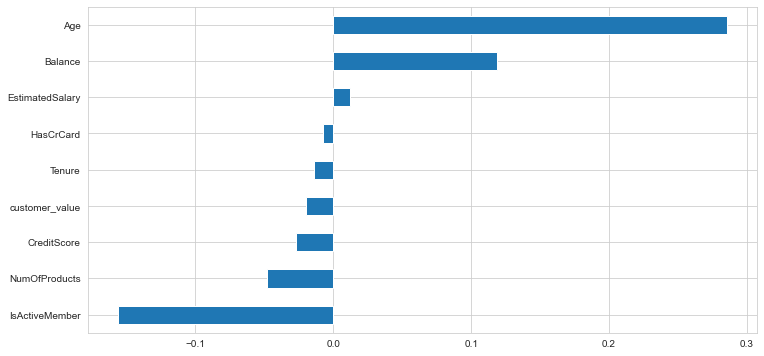

In [27]:
df.corr()['Exited'][:-1].sort_values().plot.barh();

In [28]:
df = pd.get_dummies(df)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,customer_value,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
RowNumber,,,,,,,,,,,,,,,
1,619,42,2,0.000,1,1,1,101348.880,3,1,1,0,0,1,0
2,608,41,1,83807.860,1,0,1,112542.580,2,0,0,0,1,1,0
3,502,42,8,159660.800,3,1,0,113931.570,1,1,1,0,0,1,0
4,699,39,1,0.000,2,0,0,93826.630,2,0,1,0,0,1,0
5,850,43,2,125510.820,1,1,1,79084.100,4,0,0,0,1,1,0


## Preprocessing of Data

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [30]:
X = df.drop('Exited', axis=1)
y = df['Exited'].values

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.1,
                                                    random_state=42)


In [31]:
scaler = MinMaxScaler()


In [32]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modelling & Model Performance

<span class="mark">How many hidden layers should I use? : http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-9.html (mirror: http://francky.me/aifaq/FAQ-comp.ai.neural-net.pdf)
How many hidden units should I use? : http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-10.html (mirror: http://francky.me/aifaq/FAQ-comp.ai.neural-net.pdf)
What is genetic algorithm? : https://www.researchgate.net/post/What_is_genetic_algorithm1
Genetic algorithm + neural networks: http://francky.me/doc/mrf2011-HEC-ISIR-ENS_en.pdf (chapter 2.2)</span>

### without class_weigth

In [33]:
model = Sequential()

model.add(Dense(30, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(15, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

opt = Adam(lr=0.001)
model.compile(optimizer=opt, 
              loss="binary_crossentropy",
              metrics=["Accuracy"])

<span class="burk">The patience is often set somewhere between 10 and 100 (10 or 20 is more common), but it really depends on your dataset and network.</span>

In [34]:
early_stop = EarlyStopping(monitor="val_loss",
                           mode="auto",
                           verbose=1,
                           patience=30)

In [35]:
model.fit(x=X_train,
          y=y_train,
          validation_split=.1,
          batch_size=128,
          epochs=500,
          verbose=1,
          callbacks=[early_stop])

Epoch 1/500
64/64 [==============================] - 0s 2ms/step - loss: 0.6092 - Accuracy: 0.6848 - val_loss: 0.4920 - val_Accuracy: 0.7989
Epoch 2/500
64/64 [==============================] - 0s 760us/step - loss: 0.5390 - Accuracy: 0.7822 - val_loss: 0.4776 - val_Accuracy: 0.7989
Epoch 3/500
64/64 [==============================] - 0s 776us/step - loss: 0.5244 - Accuracy: 0.7905 - val_loss: 0.4670 - val_Accuracy: 0.7989
Epoch 4/500
64/64 [==============================] - 0s 769us/step - loss: 0.5134 - Accuracy: 0.7935 - val_loss: 0.4616 - val_Accuracy: 0.7989
Epoch 5/500
64/64 [==============================] - 0s 792us/step - loss: 0.5066 - Accuracy: 0.7959 - val_loss: 0.4570 - val_Accuracy: 0.7989
Epoch 6/500
64/64 [==============================] - 0s 792us/step - loss: 0.5014 - Accuracy: 0.7951 - val_loss: 0.4549 - val_Accuracy: 0.7989
Epoch 7/500
64/64 [==============================] - 0s 776us/step - loss: 0.4893 - Accuracy: 0.7963 - val_loss: 0.4471 - val_Accuracy: 0.7989
E

Epoch 58/500
64/64 [==============================] - 0s 776us/step - loss: 0.3920 - Accuracy: 0.8354 - val_loss: 0.3237 - val_Accuracy: 0.8789
Epoch 59/500
64/64 [==============================] - 0s 760us/step - loss: 0.3957 - Accuracy: 0.8332 - val_loss: 0.3231 - val_Accuracy: 0.8778
Epoch 60/500
64/64 [==============================] - 0s 760us/step - loss: 0.3899 - Accuracy: 0.8353 - val_loss: 0.3238 - val_Accuracy: 0.8756
Epoch 61/500
64/64 [==============================] - 0s 760us/step - loss: 0.3913 - Accuracy: 0.8375 - val_loss: 0.3222 - val_Accuracy: 0.8778
Epoch 62/500
64/64 [==============================] - 0s 776us/step - loss: 0.3949 - Accuracy: 0.8346 - val_loss: 0.3225 - val_Accuracy: 0.8722
Epoch 63/500
64/64 [==============================] - 0s 772us/step - loss: 0.3897 - Accuracy: 0.8342 - val_loss: 0.3207 - val_Accuracy: 0.8756
Epoch 64/500
64/64 [==============================] - 0s 760us/step - loss: 0.3901 - Accuracy: 0.8360 - val_loss: 0.3195 - val_Accuracy:

Epoch 115/500
64/64 [==============================] - 0s 776us/step - loss: 0.3756 - Accuracy: 0.8421 - val_loss: 0.3044 - val_Accuracy: 0.8833
Epoch 116/500
64/64 [==============================] - 0s 776us/step - loss: 0.3781 - Accuracy: 0.8438 - val_loss: 0.3051 - val_Accuracy: 0.8833
Epoch 117/500
64/64 [==============================] - 0s 776us/step - loss: 0.3771 - Accuracy: 0.8421 - val_loss: 0.3039 - val_Accuracy: 0.8833
Epoch 118/500
64/64 [==============================] - 0s 760us/step - loss: 0.3764 - Accuracy: 0.8435 - val_loss: 0.3038 - val_Accuracy: 0.8811
Epoch 119/500
64/64 [==============================] - 0s 760us/step - loss: 0.3764 - Accuracy: 0.8453 - val_loss: 0.3063 - val_Accuracy: 0.8833
Epoch 120/500
64/64 [==============================] - 0s 760us/step - loss: 0.3803 - Accuracy: 0.8383 - val_loss: 0.3031 - val_Accuracy: 0.8822
Epoch 121/500
64/64 [==============================] - 0s 776us/step - loss: 0.3769 - Accuracy: 0.8436 - val_loss: 0.3033 - val_Ac

64/64 [==============================] - 0s 792us/step - loss: 0.3703 - Accuracy: 0.8453 - val_loss: 0.3007 - val_Accuracy: 0.8833
Epoch 172/500
64/64 [==============================] - 0s 776us/step - loss: 0.3720 - Accuracy: 0.8444 - val_loss: 0.3017 - val_Accuracy: 0.8856
Epoch 173/500
64/64 [==============================] - 0s 776us/step - loss: 0.3708 - Accuracy: 0.8457 - val_loss: 0.3010 - val_Accuracy: 0.8878
Epoch 174/500
64/64 [==============================] - 0s 776us/step - loss: 0.3744 - Accuracy: 0.8426 - val_loss: 0.3051 - val_Accuracy: 0.8822
Epoch 175/500
64/64 [==============================] - 0s 776us/step - loss: 0.3727 - Accuracy: 0.8441 - val_loss: 0.3015 - val_Accuracy: 0.8833
Epoch 176/500
64/64 [==============================] - 0s 776us/step - loss: 0.3741 - Accuracy: 0.8451 - val_loss: 0.3040 - val_Accuracy: 0.8822
Epoch 177/500
64/64 [==============================] - 0s 823us/step - loss: 0.3675 - Accuracy: 0.8463 - val_loss: 0.2978 - val_Accuracy: 0.8889

64/64 [==============================] - 0s 792us/step - loss: 0.3691 - Accuracy: 0.8457 - val_loss: 0.2978 - val_Accuracy: 0.8844
Epoch 228/500
64/64 [==============================] - 0s 776us/step - loss: 0.3675 - Accuracy: 0.8477 - val_loss: 0.2963 - val_Accuracy: 0.8844
Epoch 229/500
64/64 [==============================] - 0s 776us/step - loss: 0.3665 - Accuracy: 0.8463 - val_loss: 0.2939 - val_Accuracy: 0.8878
Epoch 230/500
64/64 [==============================] - 0s 776us/step - loss: 0.3673 - Accuracy: 0.8505 - val_loss: 0.2939 - val_Accuracy: 0.8911
Epoch 231/500
64/64 [==============================] - 0s 792us/step - loss: 0.3644 - Accuracy: 0.8495 - val_loss: 0.2951 - val_Accuracy: 0.8889
Epoch 232/500
64/64 [==============================] - 0s 760us/step - loss: 0.3676 - Accuracy: 0.8467 - val_loss: 0.2957 - val_Accuracy: 0.8833
Epoch 233/500
64/64 [==============================] - 0s 792us/step - loss: 0.3707 - Accuracy: 0.8452 - val_loss: 0.2984 - val_Accuracy: 0.8889

64/64 [==============================] - 0s 776us/step - loss: 0.3671 - Accuracy: 0.8477 - val_loss: 0.2983 - val_Accuracy: 0.8867
Epoch 284/500
64/64 [==============================] - 0s 807us/step - loss: 0.3714 - Accuracy: 0.8454 - val_loss: 0.2968 - val_Accuracy: 0.8822
Epoch 285/500
64/64 [==============================] - 0s 776us/step - loss: 0.3652 - Accuracy: 0.8501 - val_loss: 0.2994 - val_Accuracy: 0.8856
Epoch 286/500
64/64 [==============================] - 0s 792us/step - loss: 0.3627 - Accuracy: 0.8502 - val_loss: 0.2969 - val_Accuracy: 0.8856
Epoch 287/500
64/64 [==============================] - 0s 792us/step - loss: 0.3659 - Accuracy: 0.8490 - val_loss: 0.2946 - val_Accuracy: 0.8856
Epoch 288/500
64/64 [==============================] - 0s 792us/step - loss: 0.3662 - Accuracy: 0.8456 - val_loss: 0.2941 - val_Accuracy: 0.8889
Epoch 289/500
64/64 [==============================] - 0s 776us/step - loss: 0.3644 - Accuracy: 0.8481 - val_loss: 0.2948 - val_Accuracy: 0.8900

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                450       
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                465       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16        
Total params: 931
Trainable params: 931
Non-trainable params: 0
_________________________________________________________________


<AxesSubplot:>

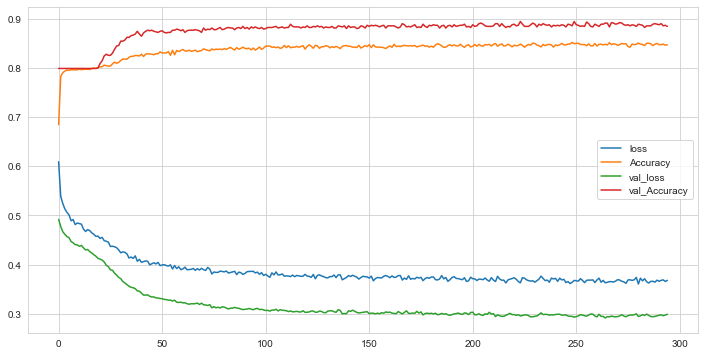

In [37]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [40]:
loss_df.nlargest(10, "val_Accuracy")

,loss,Accuracy,val_loss,val_Accuracy
223,0.363,0.848,0.296,0.894
249,0.368,0.849,0.293,0.894
255,0.368,0.845,0.295,0.893
267,0.365,0.847,0.296,0.892
271,0.369,0.847,0.296,0.892
204,0.370,0.845,0.298,0.891
229,0.367,0.850,0.294,0.891
264,0.363,0.848,0.292,0.891
265,0.364,0.847,0.294,0.891
268,0.365,0.849,0.294,0.891


In [41]:
loss_df

,loss,Accuracy,val_loss,val_Accuracy
0,0.609,0.685,0.492,0.799
1,0.539,0.782,0.478,0.799
2,0.524,0.790,0.467,0.799
3,0.513,0.793,0.462,0.799
4,0.507,0.796,0.457,0.799
...,...,...,...,...
290,0.366,0.847,0.297,0.888
291,0.368,0.847,0.298,0.890
292,0.369,0.848,0.296,0.886
293,0.366,0.846,0.297,0.887


In [42]:
y_test_pred = (model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[773  23]
 [128  76]]
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       796
           1       0.77      0.37      0.50       204

    accuracy                           0.85      1000
   macro avg       0.81      0.67      0.71      1000
weighted avg       0.84      0.85      0.83      1000



### ROC (Receiver Operating Curve) and AUC (Area Under Curve) for model

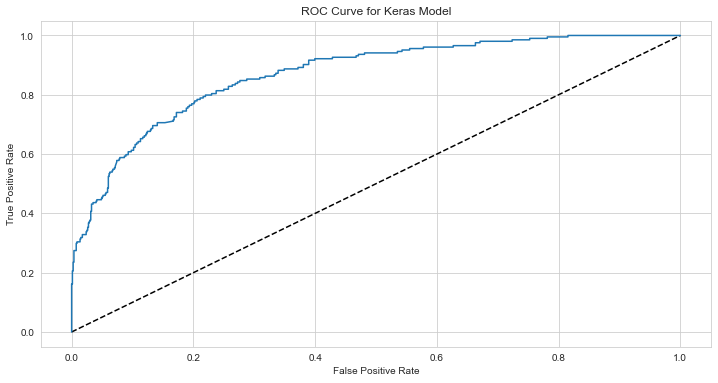

In [43]:
y_pred_proba = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Keras Model')
plt.show()

In [44]:
average_precision_score(y_test, y_pred_proba)

0.6952926754169051

### with class_weigth

In [217]:
model_weighted = Sequential()

model_weighted.add(Dense(30, activation="relu"))
model_weighted.add(Dropout(0.5))
model_weighted.add(Dense(15, activation="relu"))
model_weighted.add(Dropout(0.5))
model_weighted.add(Dense(1, activation="sigmoid"))

opt = Adam(lr=0.001)
model_weighted.compile(optimizer=opt, 
                       loss="binary_crossentropy",
                       metrics=["f1-score", "mse"])

In [218]:
early_stop = EarlyStopping(monitor="val_loss",
                           mode="auto",
                           verbose=1,
                           patience=30)

In [219]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                   classes=np.unique(y_train),
                                                   y=y_train)

class_weights = {0: class_weights[0], 1: class_weights[1]}
class_weights

{0: 0.6278777731268314, 1: 2.454991816693944}

In [220]:
model_weighted.fit(x=X_train,
                   y=y_train,
                   validation_split=.1,
                   batch_size=128,
                   epochs=200,
                   verbose=1,
                   callbacks=[early_stop],
                   class_weight=class_weights)

Epoch 1/200


ValueError: in user code:

    C:\Users\bunyaminkeles\anaconda3\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\bunyaminkeles\anaconda3\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\bunyaminkeles\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\bunyaminkeles\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\bunyaminkeles\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\bunyaminkeles\anaconda3\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\bunyaminkeles\anaconda3\lib\site-packages\keras\engine\training.py:792 train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    C:\Users\bunyaminkeles\anaconda3\lib\site-packages\keras\engine\compile_utils.py:436 update_state
        self.build(y_pred, y_true)
    C:\Users\bunyaminkeles\anaconda3\lib\site-packages\keras\engine\compile_utils.py:358 build
        self._metrics = tf.__internal__.nest.map_structure_up_to(y_pred, self._get_metric_objects,
    C:\Users\bunyaminkeles\anaconda3\lib\site-packages\tensorflow\python\util\nest.py:1376 map_structure_up_to
        return map_structure_with_tuple_paths_up_to(
    C:\Users\bunyaminkeles\anaconda3\lib\site-packages\tensorflow\python\util\nest.py:1474 map_structure_with_tuple_paths_up_to
        results = [
    C:\Users\bunyaminkeles\anaconda3\lib\site-packages\tensorflow\python\util\nest.py:1475 <listcomp>
        func(*args, **kwargs) for args in zip(flat_path_gen, *flat_value_gen)
    C:\Users\bunyaminkeles\anaconda3\lib\site-packages\tensorflow\python\util\nest.py:1378 <lambda>
        lambda _, *values: func(*values),  # Discards the path arg.
    C:\Users\bunyaminkeles\anaconda3\lib\site-packages\keras\engine\compile_utils.py:482 _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    C:\Users\bunyaminkeles\anaconda3\lib\site-packages\keras\engine\compile_utils.py:482 <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    C:\Users\bunyaminkeles\anaconda3\lib\site-packages\keras\engine\compile_utils.py:501 _get_metric_object
        metric_obj = metrics_mod.get(metric)
    C:\Users\bunyaminkeles\anaconda3\lib\site-packages\keras\metrics.py:3713 get
        return deserialize(str(identifier))
    C:\Users\bunyaminkeles\anaconda3\lib\site-packages\keras\metrics.py:3669 deserialize
        return deserialize_keras_object(
    C:\Users\bunyaminkeles\anaconda3\lib\site-packages\keras\utils\generic_utils.py:704 deserialize_keras_object
        raise ValueError(

    ValueError: Unknown metric function: f1-score. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.


<AxesSubplot:>

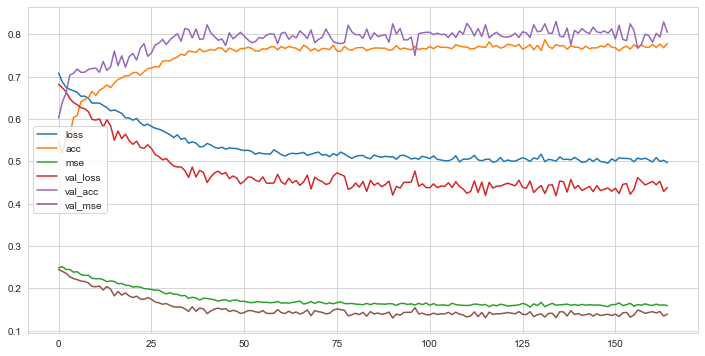

In [212]:
loss_df = pd.DataFrame(model_weighted.history.history)
loss_df.plot()

In [215]:
loss_df.nlargest(10, "acc")

,loss,acc,mse,val_loss,val_acc,val_mse
131,0.499,0.787,0.157,0.424,0.824,0.132
116,0.505,0.782,0.157,0.450,0.791,0.144
164,0.497,0.778,0.159,0.438,0.804,0.139
148,0.496,0.777,0.157,0.437,0.802,0.139
162,0.500,0.777,0.160,0.453,0.793,0.145
121,0.503,0.776,0.158,0.448,0.793,0.143
124,0.505,0.776,0.161,0.455,0.792,0.145
160,0.498,0.776,0.160,0.452,0.781,0.145
127,0.500,0.776,0.156,0.453,0.792,0.145
134,0.500,0.776,0.160,0.418,0.830,0.131


In [ ]:
loss_df 

In [216]:
y_test_pred = (model_weighted.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[618 178]
 [ 51 153]]
              precision    recall  f1-score   support

           0       0.92      0.78      0.84       796
           1       0.46      0.75      0.57       204

    accuracy                           0.77      1000
   macro avg       0.69      0.76      0.71      1000
weighted avg       0.83      0.77      0.79      1000



### ROC (Receiver Operating Curve) and AUC (Area Under Curve) for model

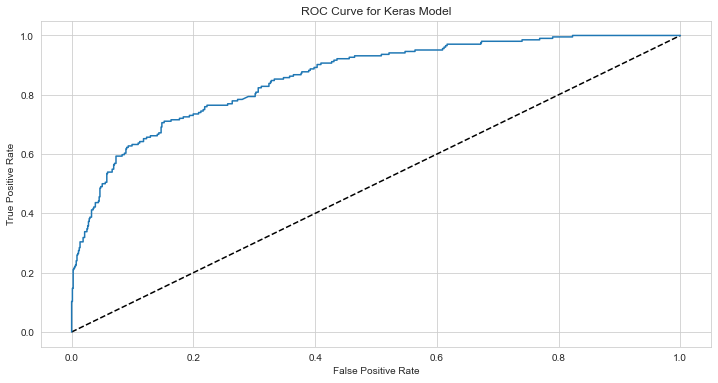

In [54]:
y_pred_proba = model_weighted.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Keras Model')
plt.show()

In [55]:
average_precision_score(y_test, y_pred_proba)

0.6784291126262612

## GridSearchCV

In [56]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [57]:
def build_classifier(optimizer):
    
    classifier = Sequential()
    classifier.add(Dense(30, activation="relu"))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(15, activation="relu"))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(1, activation="sigmoid"))
    
    classifier.compile(optimizer=optimizer,
                       loss='binary_crossentropy',
                       metrics=['Accuracy'])
    return classifier

In [58]:
class_weights

{0: 0.6278777731268314, 1: 2.454991816693944}

In [59]:
classifier = KerasClassifier(build_fn=build_classifier, epochs=150)
parameters = {'batch_size': [128, 256],
              'optimizer': [Adam, 'rmsprop', "SGD", "adagrad", "adadelta"]}

grid_model = GridSearchCV(estimator=classifier,
                          param_grid=parameters,
                          scoring='accuracy',
                          cv=5,
                          n_jobs=-1,
                          verbose=0).fit(X_train, y_train, class_weight=class_weights)

Epoch 1/150
36/36 [==============================] - 0s 712us/step - loss: 0.7294 - Accuracy: 0.5162
Epoch 2/150
36/36 [==============================] - 0s 741us/step - loss: 0.7020 - Accuracy: 0.5238
Epoch 3/150
36/36 [==============================] - 0s 712us/step - loss: 0.6914 - Accuracy: 0.5179
Epoch 4/150
36/36 [==============================] - 0s 712us/step - loss: 0.6807 - Accuracy: 0.5348
Epoch 5/150
36/36 [==============================] - 0s 741us/step - loss: 0.6789 - Accuracy: 0.5574
Epoch 6/150
36/36 [==============================] - 0s 769us/step - loss: 0.6715 - Accuracy: 0.5772
Epoch 7/150
36/36 [==============================] - 0s 741us/step - loss: 0.6690 - Accuracy: 0.5884
Epoch 8/150
36/36 [==============================] - 0s 741us/step - loss: 0.6674 - Accuracy: 0.5920
Epoch 9/150
36/36 [==============================] - 0s 712us/step - loss: 0.6602 - Accuracy: 0.6108
Epoch 10/150
36/36 [==============================] - 0s 741us/step - loss: 0.6597 - Accura

36/36 [==============================] - 0s 741us/step - loss: 0.5436 - Accuracy: 0.7602
Epoch 82/150
36/36 [==============================] - 0s 741us/step - loss: 0.5369 - Accuracy: 0.7637
Epoch 83/150
36/36 [==============================] - 0s 712us/step - loss: 0.5427 - Accuracy: 0.7638
Epoch 84/150
36/36 [==============================] - 0s 741us/step - loss: 0.5427 - Accuracy: 0.7678
Epoch 85/150
36/36 [==============================] - 0s 712us/step - loss: 0.5395 - Accuracy: 0.7628
Epoch 86/150
36/36 [==============================] - 0s 712us/step - loss: 0.5353 - Accuracy: 0.7659
Epoch 87/150
36/36 [==============================] - 0s 727us/step - loss: 0.5322 - Accuracy: 0.7632
Epoch 88/150
36/36 [==============================] - 0s 712us/step - loss: 0.5333 - Accuracy: 0.7669
Epoch 89/150
36/36 [==============================] - 0s 741us/step - loss: 0.5372 - Accuracy: 0.7681
Epoch 90/150
36/36 [==============================] - 0s 741us/step - loss: 0.5358 - Accuracy: 

In [60]:
grid_model.best_score_

0.7854444444444445

In [61]:
grid_model.best_params_

{'batch_size': 256, 'optimizer': 'rmsprop'}

In [62]:
y_test_pred = (grid_model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[617 179]
 [ 53 151]]
              precision    recall  f1-score   support

           0       0.92      0.78      0.84       796
           1       0.46      0.74      0.57       204

    accuracy                           0.77      1000
   macro avg       0.69      0.76      0.70      1000
weighted avg       0.83      0.77      0.79      1000



### ROC (Receiver Operating Curve) and AUC (Area Under Curve) for grid_model

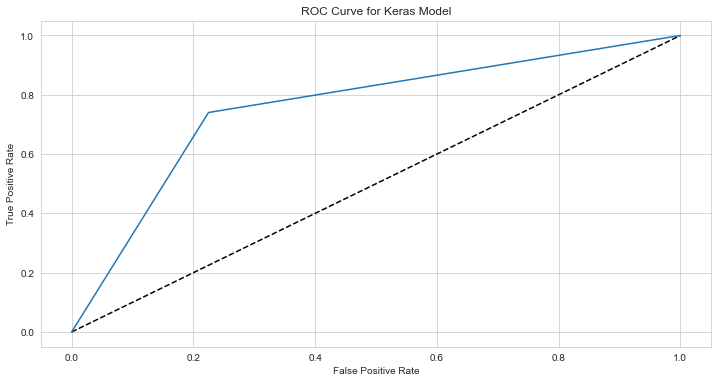

In [63]:
y_pred_proba = grid_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Keras Model')
plt.show()

In [64]:
average_precision_score(y_test, y_pred_proba)

0.39169578134284017

## Final Model and Model Deployment

In [65]:
import pickle

pickle.dump(scaler, open("scaler_churn", 'wb'))

In [66]:
final_model = Sequential()


final_model.add(Dense(30, activation="relu"))
final_model.add(Dropout(0.5))
final_model.add(Dense(15, activation="relu"))
final_model.add(Dropout(0.5))
final_model.add(Dense(1, activation="sigmoid"))

final_model.compile(optimizer="rmsprop",
                    loss="binary_crossentropy",
                    metrics=["Accuracy"])

final_model.fit(x=X_train,
                y=y_train,
                validation_data=(X_test, y_test),
                callbacks=[early_stop],
                batch_size=128,
                epochs=200,
                verbose=1,
                class_weight=class_weights)

Epoch 1/200
71/71 [==============================] - 0s 2ms/step - loss: 0.7035 - Accuracy: 0.4731 - val_loss: 0.6444 - val_Accuracy: 0.7360
Epoch 2/200
71/71 [==============================] - 0s 741us/step - loss: 0.6826 - Accuracy: 0.5500 - val_loss: 0.6499 - val_Accuracy: 0.6990
Epoch 3/200
71/71 [==============================] - 0s 741us/step - loss: 0.6735 - Accuracy: 0.5818 - val_loss: 0.6609 - val_Accuracy: 0.6440
Epoch 4/200
71/71 [==============================] - 0s 755us/step - loss: 0.6650 - Accuracy: 0.5953 - val_loss: 0.6379 - val_Accuracy: 0.7040
Epoch 5/200
71/71 [==============================] - 0s 741us/step - loss: 0.6607 - Accuracy: 0.6400 - val_loss: 0.6354 - val_Accuracy: 0.6960
Epoch 6/200
71/71 [==============================] - 0s 755us/step - loss: 0.6547 - Accuracy: 0.6442 - val_loss: 0.6377 - val_Accuracy: 0.6880
Epoch 7/200
71/71 [==============================] - 0s 755us/step - loss: 0.6541 - Accuracy: 0.6632 - val_loss: 0.6338 - val_Accuracy: 0.6910
E

Epoch 58/200
71/71 [==============================] - 0s 791us/step - loss: 0.5318 - Accuracy: 0.7780 - val_loss: 0.4803 - val_Accuracy: 0.7920
Epoch 59/200
71/71 [==============================] - 0s 769us/step - loss: 0.5308 - Accuracy: 0.7760 - val_loss: 0.4683 - val_Accuracy: 0.8020
Epoch 60/200
71/71 [==============================] - 0s 769us/step - loss: 0.5224 - Accuracy: 0.7818 - val_loss: 0.4901 - val_Accuracy: 0.7780
Epoch 61/200
71/71 [==============================] - 0s 784us/step - loss: 0.5285 - Accuracy: 0.7767 - val_loss: 0.4895 - val_Accuracy: 0.7870
Epoch 62/200
71/71 [==============================] - 0s 747us/step - loss: 0.5283 - Accuracy: 0.7787 - val_loss: 0.4895 - val_Accuracy: 0.7800
Epoch 63/200
71/71 [==============================] - 0s 741us/step - loss: 0.5225 - Accuracy: 0.7761 - val_loss: 0.4899 - val_Accuracy: 0.7780
Epoch 64/200
71/71 [==============================] - 0s 741us/step - loss: 0.5277 - Accuracy: 0.7766 - val_loss: 0.4870 - val_Accuracy:

Epoch 115/200
71/71 [==============================] - 0s 744us/step - loss: 0.5168 - Accuracy: 0.7879 - val_loss: 0.4789 - val_Accuracy: 0.7780
Epoch 116/200
71/71 [==============================] - 0s 741us/step - loss: 0.5129 - Accuracy: 0.7893 - val_loss: 0.4660 - val_Accuracy: 0.8000
Epoch 117/200
71/71 [==============================] - 0s 746us/step - loss: 0.5159 - Accuracy: 0.7883 - val_loss: 0.4803 - val_Accuracy: 0.7840
Epoch 118/200
71/71 [==============================] - 0s 741us/step - loss: 0.5238 - Accuracy: 0.7796 - val_loss: 0.4739 - val_Accuracy: 0.7910
Epoch 119/200
71/71 [==============================] - 0s 784us/step - loss: 0.5172 - Accuracy: 0.7883 - val_loss: 0.4786 - val_Accuracy: 0.7920
Epoch 120/200
71/71 [==============================] - 0s 741us/step - loss: 0.5091 - Accuracy: 0.7860 - val_loss: 0.4550 - val_Accuracy: 0.8050
Epoch 121/200
71/71 [==============================] - 0s 755us/step - loss: 0.5166 - Accuracy: 0.7908 - val_loss: 0.4820 - val_Ac

71/71 [==============================] - 0s 751us/step - loss: 0.5156 - Accuracy: 0.7833 - val_loss: 0.4723 - val_Accuracy: 0.7930
Epoch 172/200
71/71 [==============================] - 0s 755us/step - loss: 0.5101 - Accuracy: 0.7922 - val_loss: 0.4661 - val_Accuracy: 0.8020
Epoch 173/200
71/71 [==============================] - 0s 737us/step - loss: 0.5090 - Accuracy: 0.7899 - val_loss: 0.4574 - val_Accuracy: 0.8020
Epoch 174/200
71/71 [==============================] - 0s 741us/step - loss: 0.5080 - Accuracy: 0.7898 - val_loss: 0.4651 - val_Accuracy: 0.8040
Epoch 00174: early stopping


<AxesSubplot:>

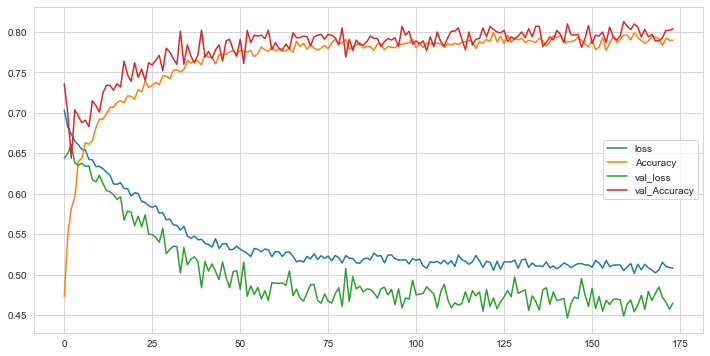

In [67]:
loss_df = pd.DataFrame(final_model.history.history)
loss_df.plot()

In [68]:
loss_df

,loss,Accuracy,val_loss,val_Accuracy
0,0.704,0.473,0.644,0.736
1,0.683,0.550,0.650,0.699
2,0.673,0.582,0.661,0.644
3,0.665,0.595,0.638,0.704
4,0.661,0.640,0.635,0.696
...,...,...,...,...
169,0.506,0.792,0.485,0.789
170,0.516,0.783,0.472,0.793
171,0.510,0.792,0.466,0.802
172,0.509,0.790,0.457,0.802


In [69]:
loss_df.nlargest(10, "val_Accuracy")

,loss,Accuracy,val_loss,val_Accuracy
159,0.505,0.796,0.449,0.813
143,0.512,0.788,0.447,0.810
162,0.502,0.799,0.454,0.810
149,0.512,0.782,0.461,0.808
96,0.518,0.785,0.459,0.807
121,0.515,0.789,0.461,0.807
134,0.511,0.787,0.467,0.807
135,0.511,0.792,0.456,0.807
160,0.510,0.796,0.464,0.807
155,0.510,0.786,0.463,0.806


In [70]:
y_test_pred = (final_model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[653 143]
 [ 53 151]]
              precision    recall  f1-score   support

           0       0.92      0.82      0.87       796
           1       0.51      0.74      0.61       204

    accuracy                           0.80      1000
   macro avg       0.72      0.78      0.74      1000
weighted avg       0.84      0.80      0.82      1000



In [ ]:
final_model.save('model_churn.h5')

### Prediction

In [ ]:
single_customer = df.drop('Exited', axis=1).iloc[0]
single_customer

In [ ]:
single_customer = scaler.transform(single_customer.values.reshape(-1, 14))
single_customer

In [ ]:
(final_model.predict(single_customer) > 0.5).astype("int32")

In [ ]:
df["Exited"].iloc[0]

---
---

## Comparison with ML

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [ ]:
clf1 = RandomForestClassifier(random_state=42, class_weight="balanced")
clf2 = SVC(probability=True, random_state=42, class_weight="balanced")
clf3 = LogisticRegression(random_state=42, class_weight="balanced")

In [ ]:
# Initiaze the hyperparameters for each dictionary
param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__max_depth'] = [5, 10, 20]
param1['classifier'] = [clf1]

param2 = {}
param2['classifier__C'] = [10**(-2+i) for i in range(5)]
param2['classifier'] = [clf2]

param3 = {}
param3['classifier__C'] = [10**(-2+i) for i in range(5)]
param3['classifier__penalty'] = ['l1', 'l2']
param3['classifier'] = [clf3]

In [ ]:
pipeline = Pipeline([('classifier', clf1)])
params = [param1, param2, param3]

In [ ]:
grid_model_rf = GridSearchCV(pipeline, params, cv=5, n_jobs=-1,
                          scoring='accuracy').fit(X_train, y_train)

In [ ]:
grid_model_rf.best_params_

In [ ]:
grid_model_rf.best_score_

In [ ]:
y_pred_proba = grid_model_rf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Keras Model')
plt.show()

In [ ]:
average_precision_score(y_test, y_pred_proba)

In [ ]:
y_test_pred = (grid_model_rf.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

# SVC

In [ ]:
pipeline = Pipeline([('classifier', clf2)])
params = [param1, param2, param3]

In [ ]:
grid_model_svc = GridSearchCV(pipeline, params, cv=5, n_jobs=-1,
                          scoring='accuracy').fit(X_train, y_train)

In [ ]:
grid_model_svc.best_params_

In [ ]:
grid_model_svc.best_score_

In [ ]:
y_pred_proba = grid_model_svc.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Keras Model')
plt.show()

In [ ]:
average_precision_score(y_test, y_pred_proba)

In [ ]:
y_test_pred = (grid_model_svc.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

# LR

In [ ]:
pipeline = Pipeline([('classifier', clf3)])
params = [param1, param2, param3]

In [ ]:
grid_model_lr = GridSearchCV(pipeline, params, cv=5, n_jobs=-1,
                          scoring='accuracy').fit(X_train, y_train)

In [ ]:
grid_model_lr.best_params_

In [ ]:
grid_model_lr.best_score_

In [ ]:
y_pred_proba = grid_model_lr.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Keras Model')
plt.show()

In [ ]:
average_precision_score(y_test, y_pred_proba)

In [ ]:
y_test_pred = (grid_model_lr.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

---
---